In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import math
from torch.utils.data import DataLoader, TensorDataset,RandomSampler
from math import exp, sqrt,pi
import time

import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [31]:


def Loss_BC(xb,yb,xb_Neumann_up,yb_Neumann_up ,xb_Neumann_down,yb_Neumann_down,cb):
		

		xb_Neumann_up.requires_grad = True
		yb_Neumann_up.requires_grad = True
		xb_Neumann_down.requires_grad = True
		yb_Neumann_down.requires_grad = True

		net_in = torch.cat((xb, yb), 1)
		out = net(net_in )


		c_bc = out.view(len(out), -1)

		loss_f = nn.MSELoss()
		loss_bc_Dirichlet_left = loss_f(c_bc, cb)  #The Dirichlet BC (left)


		net_in_up = torch.cat((xb_Neumann_up, yb_Neumann_up), 1)
		out_n = net(net_in_up )
		c_n_up = out_n.view(len(out_n), -1)
		loss_bc_match = loss_f(c_n_up , torch.zeros_like(c_n_up) )  #The Dirichlet BC (up)

		net_in_down = torch.cat((xb_Neumann_down, yb_Neumann_down), 1)
		out_n = net(net_in_down )
		c_n_down = out_n.view(len(out_n), -1)

		c_y_down = torch.autograd.grad(c_n_down,yb_Neumann_down,grad_outputs=torch.ones_like(yb_Neumann_down),create_graph = True,only_inputs=True)[0]

		loss_bc_Neumann_down = loss_f(c_y_down, flux_BC* math.sqrt(eps)*A* torch.ones_like(c_y_down))  #The flux Neumann BC bottom

		loss_bc = loss_bc_Dirichlet_left + loss_bc_match + loss_bc_Neumann_down

		return loss_bc





tensor([[-1.0000, -1.0000],
        [-0.9798, -1.0000],
        [-0.9596, -1.0000],
        ...,
        [ 0.9596,  1.0000],
        [ 0.9798,  1.0000],
        [ 1.0000,  1.0000]], grad_fn=<CatBackward0>)
Train Epoch: 0 	Loss: 10.3942489624 	 Loss BC 1.035649
tensor([[-1.0000, -1.0000],
        [-0.9798, -1.0000],
        [-0.9596, -1.0000],
        ...,
        [ 0.9596,  1.0000],
        [ 0.9798,  1.0000],
        [ 1.0000,  1.0000]], grad_fn=<CatBackward0>)
tensor([[-1.0000, -1.0000],
        [-0.9798, -1.0000],
        [-0.9596, -1.0000],
        ...,
        [ 0.9596,  1.0000],
        [ 0.9798,  1.0000],
        [ 1.0000,  1.0000]], grad_fn=<CatBackward0>)
tensor([[-1.0000, -1.0000],
        [-0.9798, -1.0000],
        [-0.9596, -1.0000],
        ...,
        [ 0.9596,  1.0000],
        [ 0.9798,  1.0000],
        [ 1.0000,  1.0000]], grad_fn=<CatBackward0>)
tensor([[-1.0000, -1.0000],
        [-0.9798, -1.0000],
        [-0.9596, -1.0000],
        ...,
        [ 0.9596,  1.000

KeyboardInterrupt: 

In [ ]:

def train(device,x,y,xb,yb,cb,learning_rate,eps,c,f,epochs):
	x = torch.Tensor(x).to(device)
	y = torch.Tensor(y).to(device) 
	xb = torch.Tensor(xb).to(device) 	
	yb = torch.Tensor(yb).to(device) 
	cb = torch.Tensor(cb).to(device)

	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.main = nn.Sequential(
				nn.Linear(input_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				#Swish(),
				#nn.Linear(h_n,h_n),
				#Swish(),
				#nn.Linear(h_n,h_n),
        		Swish(),
				nn.Linear(h_n,1),
			)		
		def forward(self,x):		
			output = self.main(x)
			return  output

	
	net = Net().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer2 = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def criterion(x,y):
		x.requires_grad = True
		y.requires_grad = True
		points = torch.cat((x,y),1) 
		U = net(points)
		U = U.view(len(U),-1)
		U_x = torch.autograd.grad(U,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_x = torch.autograd.grad(U,x,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,x,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,x,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,x,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - eps*(U_xx + U_yy) + c*U - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb,yb,ub):
		
		xb1,xb2,xb3,xb4 = xb
		yb1,yb2,yb3,yb4 = yb
		ub1,ub2,ub3,ub4 = ub
		loss_bc = 0

		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1_pred = out1.view(len(out1), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub1_pred,ub1)
		
		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2_pred = out2.view(len(out2), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub2_pred,ub2)

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3_pred = out3.view(len(out3), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub3_pred,ub3)

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4_pred = out4.view(len(out4), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub4_pred,ub4)

		return loss_bc


	
	losses = []
	tic = time.time()


	for epoch in range(epochs):
		net.zero_grad()
		loss_eqn = criterion(x,y)
		loss_bc = Loss_BC(xb,yb, cb)
		loss = loss_eqn + loss_bc
		loss.backward()
			
		optimizer2.step() 
		if epoch % 10 ==0:
			print('Train Epoch: {} \tLoss: {:.10f} \t Loss BC {:.6f}'.format(
				epoch, loss.item(),loss_bc.item()))
			losses.append(loss.item())

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((x,y),1)
	output = net(net_in)  #evaluate model
	
	return output 


device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-5   

epochs = 500 

n = 100 

x = np.linspace(-1.,1.,100 )
y = np.linspace(-1.,1.,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(-1.,1., 100 )
yb1 = np.linspace(-1.,-1., 100 ) 
cb1 = xb1*yb1
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)
cb1 = cb1.reshape(-1, 1)

xb2 = np.linspace(-1.,1., 100 )
yb2 = np.linspace(1.,1., 100 ) 
cb2 = xb2*yb2
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)
cb2 = cb2.reshape(-1, 1)

xb3 = np.linspace(1.,1., 100 )
yb3 = np.linspace(-1.,1., 100 ) 
cb3 = xb3*yb3
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)
cb3 = cb3.reshape(-1, 1)

xb4 = np.linspace(-1.,-1., 100 )
yb4 = np.linspace(-1.,1., 100 ) 
cb4 = xb4*yb4
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)
cb4 = cb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]
cb = [cb1,cb2,cb3,cb4]

output = train(device,x,y,xb,yb,cb,learning_rate,epochs)



In [2]:

def train(device,x,y,xb,yb,cb,learning_rate,epochs):
	x = torch.Tensor(x).to(device)
	y = torch.Tensor(y).to(device) 
	xb = torch.Tensor(xb).to(device) 	
	yb = torch.Tensor(yb).to(device) 
	cb = torch.Tensor(cb).to(device)

	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.main = nn.Sequential(
				nn.Linear(input_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
        		Swish(),
				nn.Linear(h_n,1),
			)		
		def forward(self,x):		
			output = self.main(x)
			return  output

	
	net = Net().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer2 = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def criterion(x,y):
		x.requires_grad = True
		y.requires_grad = True
		points = torch.cat((x,y),1) 
		U = net(points)
		U = U.view(len(U),-1)
		U_x = torch.autograd.grad(U,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		loss1 = U_xx + U_yy
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb,yb,ub):
		
		xb1,xb2,xb3,xb4 = xb
		yb1,yb2,yb3,yb4 = yb
		ub1,ub2,ub3,ub4 = ub
		loss_bc = 0

		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1_pred = out1.view(len(out1), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub1_pred,ub1)
		
		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2_pred = out2.view(len(out2), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub2_pred,ub2)

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3_pred = out3.view(len(out3), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub3_pred,ub3)

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4_pred = out4.view(len(out4), -1)
		loss_f = nn.MSELoss()
		loss_bc += loss_f(ub4_pred,ub4)

		return loss_bc


	
	losses = []
	tic = time.time()


	for epoch in range(epochs):
		net.zero_grad()
		loss_eqn = criterion(x,y)
		loss_bc = Loss_BC(xb,yb, cb)
		loss = loss_eqn + loss_bc
		loss.backward()
			
		optimizer2.step() 
		if epoch % 10 ==0:
			print('Train Epoch: {} \tLoss: {:.10f} \t Loss BC {:.6f}'.format(
				epoch, loss.item(),loss_bc.item()))
			losses.append(loss.item())

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((x,y),1)
	output = net(net_in)  #evaluate model
	
	return output 


device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-5   

epochs = 500 

n = 100 

x = np.linspace(-1.,1.,100 )
y = np.linspace(-1.,1.,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(-1.,1., 100 )
yb1 = np.linspace(-1.,-1., 100 ) 
cb1 = xb1*yb1
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)
cb1 = cb1.reshape(-1, 1)

xb2 = np.linspace(-1.,1., 100 )
yb2 = np.linspace(1.,1., 100 ) 
cb2 = xb2*yb2
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)
cb2 = cb2.reshape(-1, 1)

xb3 = np.linspace(1.,1., 100 )
yb3 = np.linspace(-1.,1., 100 ) 
cb3 = xb3*yb3
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)
cb3 = cb3.reshape(-1, 1)

xb4 = np.linspace(-1.,-1., 100 )
yb4 = np.linspace(-1.,1., 100 ) 
cb4 = xb4*yb4
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)
cb4 = cb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]
cb = [cb1,cb2,cb3,cb4]

output = train(device,x,y,xb,yb,cb,learning_rate,epochs)



C:\Users\bsaty\AppData\Local\Temp\ipykernel_22488\771369024.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  xb = torch.Tensor(xb).to(device)


Train Epoch: 0 	Loss: 1.4457473755 	 Loss BC 1.289424
Train Epoch: 10 	Loss: 1.3098587990 	 Loss BC 1.193327
Train Epoch: 20 	Loss: 1.1914734840 	 Loss BC 1.099490
Train Epoch: 30 	Loss: 1.0859156847 	 Loss BC 1.008535
Train Epoch: 40 	Loss: 0.9901971221 	 Loss BC 0.921500
Train Epoch: 50 	Loss: 0.9025596380 	 Loss BC 0.839192
Train Epoch: 60 	Loss: 0.8217786551 	 Loss BC 0.761967
Train Epoch: 70 	Loss: 0.7470001578 	 Loss BC 0.689786
Train Epoch: 80 	Loss: 0.6776490211 	 Loss BC 0.622407
Train Epoch: 90 	Loss: 0.6133258343 	 Loss BC 0.559601
Train Epoch: 100 	Loss: 0.5537437201 	 Loss BC 0.501235
Train Epoch: 110 	Loss: 0.4986822903 	 Loss BC 0.447238
Train Epoch: 120 	Loss: 0.4479543567 	 Loss BC 0.397540
Train Epoch: 130 	Loss: 0.4013834894 	 Loss BC 0.352046
Train Epoch: 140 	Loss: 0.3587912917 	 Loss BC 0.310637
Train Epoch: 150 	Loss: 0.3199867010 	 Loss BC 0.273162
Train Epoch: 160 	Loss: 0.2847614884 	 Loss BC 0.239431
Train Epoch: 170 	Loss: 0.2528888285 	 Loss BC 0.209228
Tra

In [16]:
z = output.detach().numpy()
x = np.linspace(-1.,1.,100 )
y = np.linspace(-1.,1.,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1)) 

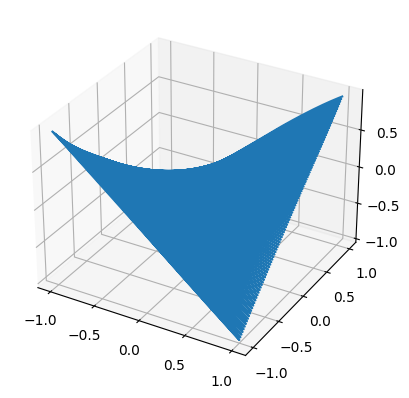

In [17]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z)
plt.show()